In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import glob
import torch
from torch import nn
import torch.nn.functional as F
import  torch.optim as optim
from    matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(device)

cuda


In [3]:
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame

In [4]:
def get_data():
    dataset_conc=[]
    path=r'Dataset'
    all_files=glob.glob(path+"/*.csv")
    for filename in all_files:
        df=pd.read_csv(filename,index_col=None,header=0)
        #将数据中value为0的替换成NaN
        df=df.replace(0,np.nan)
        #处理value那层数据，将0去除掉
        df=df.dropna(axis=0, how='any',subset=['value'])
        df.value = preprocessing.normalize([df.value]).T
        dataset_conc.append(convert_2d(df))
    frame=pd.concat(dataset_conc,axis=0,ignore_index=True)
    y = frame.iloc[:, 60]
    X = frame.iloc[:, 0:60]
    X_train = X[:int(X.shape[0] * 0.7)]
    X_test = X[int(X.shape[0] * 0.7):]
    y_train = y[:int(X.shape[0] * 0.7)]
    y_test = y[int(X.shape[0] * 0.7):]


    X_train = X_train.to_numpy()
    nrows, ncols = X_train.shape
    X_train = X_train.reshape(nrows, ncols, 1)

    X_test = X_test.to_numpy()
    nrows, ncols = X_test.shape
    X_test = X_test.reshape(nrows, ncols, 1)

    y_test = y_test.to_numpy()
    # print("X_train:",X_train.shape)
    #[62107,60,1]
    # print("y_train:",y_train.shape)
    #[62107,]
    return X_train,y_train,X_test,y_test

In [5]:
X_train,y_train,X_test,y_test=get_data()

In [6]:
# 定义实现因果卷积的类
from torch.nn.utils import weight_norm
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# 定义了一个残差模块
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # n_inputs:输入通道数
        # n_outputs:输出通道数
        # stride：步长
        # padding:填充长度
        # dilation：扩张率
        # 定义第一个空洞卷积层
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 根据第一个卷积层的输出与padding大小实现因果卷积
        self.chomp1 = Chomp1d(padding)
        # 添加激活函数与dropout正则化方法完成第一个卷积
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # 堆叠同样结构的第二个卷积层
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # 将卷积模块的所有组建通过Sequential方法依次堆叠在一起
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # 如果输出纬度和输入维度不一致，则必须对输出进行1X1卷积
        # 如果通道数不一样，那么需要对输入x做一个逐元素的一维卷积以使得它的纬度与前面两个卷积相等。
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        # 不同激活函数的尝试
        # self.sigmod = nn.Softmax()
        # self.tanh = nn.Tanh()
        # self.softPlus = nn.Softplus()
        # self.leaky = nn.LeakyReLU()
        self.init_weights()

    # 初始化为从均值为0，标准差为0.01的正态分布中采样的随机值
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    # 结合卷积与输入的恒等映射（或输入的逐元素卷积），并投入ReLU 激活函数完成残差模块
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


# 时间卷积网络
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.5):
        super(TemporalConvNet, self).__init__()
        # num_input:输入特征数，默认为1
        # num_levels:网络层数，每一层是一个残差块
        # num_channels:储存了所有层级的输出通道数
        layers = []
        # num_channels为各层卷积运算的输出通道数或卷积核数量
        num_levels = len(num_channels)
        # 空洞卷积的扩张系数若随着网络层级的增加而成指数级增加，则可以增大感受野并不丢弃任何输入序列的元素
        # dilation_size根据层级数成指数增加，并从num_channels中抽取每一个残差模块的输入通道数与输出通道数
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        # 将所有残差模块堆叠起来组成一个深度卷积网络
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x=self.network(x)
        #print('tcn_shape:',x.shape)
        return x

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv=nn.Sequential(
            #[512,1,60]
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            #[512,32,30]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,15]
            TemporalConvNet(64,[64,64,64]),
            nn.ReLU(),
            # nn.MaxPool1d(2, stride=2),
#             nn.Dropout(0.2),
#             TemporalConvNet(64,[64]),
#             nn.ReLU(),
#             nn.MaxPool1d(2, stride=2),
            #[512,64,15]
        )
        self.lstm=nn.LSTM(input_size=960, hidden_size=64,num_layers=1,batch_first=True,bidirectional=True)
        self.fc=nn.Sequential(
            nn.ReLU(),
            nn.Flatten(),
            #[512,128]
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,2),
            #[512,2]
            nn.Softmax(dim=1)
        )

    def forward(self,x):
        out=self.conv(x)
        # out=self.tcn(x)
        out=out.reshape(-1,1,960)
        #[512,1,960]
        out,_=self.lstm(out)
        #[512,1,128]
        out=self.fc(out)
        #[512,2]
        return out

In [26]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv=nn.Sequential(
            #[512,1,60]
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            #[512,32,30]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,15]
            TemporalConvNet(64,[64,64,64]),
            nn.ReLU(),
            # nn.MaxPool1d(2, stride=2),
#             nn.Dropout(0.2),
#             TemporalConvNet(64,[64]),
#             nn.ReLU(),
#             nn.MaxPool1d(2, stride=2),
            #[512,64,15]
        )
        self.gru=nn.GRU(input_size=960, hidden_size=64, num_layers=1,batch_first=True,bidirectional=True)
        self.fc=nn.Sequential(
            nn.ReLU(),
            nn.Flatten(),
            #[512,128]
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,2),
            #[512,2]
            nn.Softmax(dim=1)
        )

    def forward(self,x):
        out=self.conv(x)
        # out=self.tcn(x)
        out=out.reshape(-1,1,960)
        #[512,1,960]
        out,_=self.gru(out)
        #[512,1,128]
        out=self.fc(out)
        #[512,2]
        return out

In [35]:
loss_list=[]
epoch_list=[]
acc_list=[]
ans_acc_list=[]
train_acc_list=[]

In [39]:

loss_list2=[]
epoch_list2=[]
acc_list2=[]
ans_acc_list2=[]
train_acc_list2=[]

In [29]:
import torch.utils.data as Data
from numpy import *
def train(input,y_train,X_test,y_test,new_input,new_y_train):
    torch_dataset=Data.TensorDataset(input,y_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        shuffle=True,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多进程（multiprocess）来读数据
    )

    net = Net()
    net=net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    net.train()

    for epoch in range(401):
        # 在一轮中迭代获取每个batch（把全部的数据分成小块一块块的训练）
        net.train()
        for step, (batch_x, batch_y) in enumerate(loader):
            input=batch_x.to(device)
            label=batch_y.to(device)
            # print("input:",input.shape)
            #[512,1,60]
            # print("label:",label.shape)
            #[512,2]
            y_pred=net(input)
            loss = F.binary_cross_entropy(y_pred,label)
            optimizer.zero_grad()
            loss.backward()
#             for p in net.parameters():
#               # print(p.grad.norm())                 # 查看参数p的梯度
#               torch.nn.utils.clip_grad_norm_(p, 10)  # 将梯度裁剪到小于10
            optimizer.step()
        flag=False
        if epoch%30==0:
          flag=True
        acc=test(net,X_test,y_test,flag)
        train_acc=test(net,new_input,new_y_train,flag)
        print('epoch', epoch, ':', loss.item(),'train_acc',train_acc,'test_acc：',acc)
        acc_list.append(acc)
        ans_acc_list.append(acc)
        train_acc_list.append(train_acc)
        loss_list.append(loss.item())
        epoch_list.append(epoch)
        if epoch%100==0:
            print("acc平均值：",round(mean(acc_list),4))
            acc_list.clear()
    torch.save(net.state_dict(),'model/net_cnn_tcn_Bilstm_params.pth')
    plt.plot(epoch_list,loss_list,color='red',label='training Loss')
    plt.plot(epoch_list,ans_acc_list,color='green',label='test Acc')
    plt.plot(epoch_list,train_acc_list,color='blue',label='training Acc')
    plt.legend()
    plt.show()

    return net

In [30]:
import torch.utils.data as Data
from numpy import *
def train2(input,y_train,X_test,y_test,new_input,new_y_train):
    torch_dataset=Data.TensorDataset(input,y_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        shuffle=True,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多进程（multiprocess）来读数据
    )
    # print(len(loader))
    #122
    net = Net2()
    net=net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    net.train()

    for epoch in range(401):
        # 在一轮中迭代获取每个batch（把全部的数据分成小块一块块的训练）
        net.train()
        for step, (batch_x, batch_y) in enumerate(loader):
            input=batch_x.to(device)
            label=batch_y.to(device)
            # print("input:",input.shape)
            #[512,1,60]
            # print("label:",label.shape)
            #[512,2]
            y_pred=net(input)
            loss = F.binary_cross_entropy(y_pred,label)
            optimizer.zero_grad()
            loss.backward()
#             for p in net.parameters():
#               # print(p.grad.norm())                 # 查看参数p的梯度
#               torch.nn.utils.clip_grad_norm_(p, 10)  # 将梯度裁剪到小于10
            optimizer.step()
        flag=False
        if epoch%30==0:
          flag=True
        acc=test(net,X_test,y_test,flag)
        train_acc=test(net,new_input,new_y_train,flag)
        print('epoch', epoch, ':', loss.item(),'train_acc',train_acc,'test_acc：',acc)
        acc_list2.append(acc)
        ans_acc_list2.append(acc)
        train_acc_list2.append(train_acc)
        loss_list2.append(loss.item())
        epoch_list2.append(epoch)
        if epoch%100==0:
            print("acc平均值：",round(mean(acc_list2),4))
            acc_list2.clear()
    torch.save(net.state_dict(),'model/net_cnn_tcn_Bigru_params.pth')
    plt.plot(epoch_list2,loss_list2,color='red',label='training Loss')
    plt.plot(epoch_list2,ans_acc_list2,color='green',label='test Acc')
    plt.plot(epoch_list2,train_acc_list2,color='blue',label='training Acc')
    plt.legend()
    plt.show()

    return net

In [13]:
def test(model,x_test,y_test,flag):
    model.eval()
    torch_dataset=Data.TensorDataset(x_test,y_test)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        num_workers=0,  # 多进程（multiprocess）来读数据
    )

    acc = 0.0
    count = 0
    ans_labels=[]
    ans_pre=[]
    for index, data in enumerate(loader):
        inputs, labels = data  # 5,3,400,600  5,10
        count += len(labels)
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs = model(inputs)
        _, predict = torch.max(outputs, 1)
        acc += (labels == predict).sum().item()
        ans_labels+=labels.cpu().numpy().tolist()
        ans_pre+=predict.cpu().numpy().tolist()
    #evaluate performance
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    if flag==True:
      Confusion_Matrix = confusion_matrix(ans_labels, ans_pre)
      Accuracy = accuracy_score(ans_labels, ans_pre)
      precision = precision_score(ans_labels, ans_pre, average='binary')
      recall = recall_score(ans_labels, ans_pre, average='binary')
      F1_Score = f1_score(ans_labels, ans_pre, average='binary')
      print("Confusion_Matrix")
      print(Confusion_Matrix)
      print("Accuracy ", Accuracy)
      print("Precision ", precision)
      print("recall ", recall)
      print("f1_score ", F1_Score)
    return round(acc/count,4)

In [14]:
new_y_train=y_train
new_y_train=torch.tensor(new_y_train)
new_x_train=X_train
new_input=torch.tensor(new_x_train).permute(0,2,1).to(torch.float32)
y_train=F.one_hot(torch.tensor(y_train).to(torch.int64),2)
y_train=y_train.to(torch.float32)
#[batch_size,seq_len,embedding_size]=>[batch_size,embeding_size,seq_len]
input=torch.tensor(X_train).permute(0,2,1).to(torch.float32)
X_test = torch.tensor(X_test).permute(0, 2, 1).to(torch.float32)
y_test=torch.tensor(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[24520     0]
 [ 2098     0]]
Accuracy  0.9211811556089864
Precision  0.0
recall  0.0
f1_score  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[55732     0]
 [ 6375     0]]
Accuracy  0.8973545655079138
Precision  0.0
recall  0.0
f1_score  0.0
epoch 0 : 0.29125329852104187 train_acc 0.8974 test_acc： 0.9212
acc平均值： 0.9212
epoch 1 : 0.4303252100944519 train_acc 0.8974 test_acc： 0.9212
epoch 2 : 0.41632819175720215 train_acc 0.8974 test_acc： 0.9212
epoch 3 : 0.30359581112861633 train_acc 0.8974 test_acc： 0.9212
epoch 4 : 0.30442294478416443 train_acc 0.8974 test_acc： 0.9212
epoch 5 : 0.3040311932563782 train_acc 0.8974 test_acc： 0.9212
epoch 6 : 0.3148696720600128 train_acc 0.8974 test_acc： 0.9212
epoch 7 : 0.3387613892555237 train_acc 0.8974 test_acc： 0.9212
epoch 8 : 0.2514895796775818 train_acc 0.9021 test_acc： 0.9256
epoch 9 : 0.29353800415992737 train_acc 0.912 test_acc： 0.9279
epoch 10 : 0.41338038444519043 train_acc 0.9176 test_acc： 0.9289
epoch 11 : 0.3089143633842468 train_acc 0.9202 test_acc： 0.9315
epoch 12 : 0.2840665578842163 train_acc 0.9236 test_acc： 0.9359
epoch 13 : 0.15572090446949005 train_acc

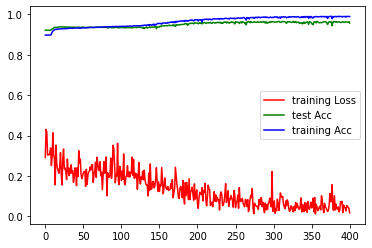

In [36]:
model=train(input,y_train,X_test,y_test,new_input,new_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[24520     0]
 [ 2098     0]]
Accuracy  0.9211811556089864
Precision  0.0
recall  0.0
f1_score  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[55732     0]
 [ 6375     0]]
Accuracy  0.8973545655079138
Precision  0.0
recall  0.0
f1_score  0.0
epoch 0 : 0.3148587942123413 train_acc 0.8974 test_acc： 0.9212
acc平均值： 0.9212
epoch 1 : 0.2903549373149872 train_acc 0.8974 test_acc： 0.9212
epoch 2 : 0.4004446268081665 train_acc 0.8974 test_acc： 0.9212
epoch 3 : 0.39049792289733887 train_acc 0.8974 test_acc： 0.9212
epoch 4 : 0.31647855043411255 train_acc 0.8974 test_acc： 0.9212
epoch 5 : 0.2722974121570587 train_acc 0.8974 test_acc： 0.9212
epoch 6 : 0.2859000563621521 train_acc 0.8974 test_acc： 0.9212
epoch 7 : 0.3516179323196411 train_acc 0.8974 test_acc： 0.9212
epoch 8 : 0.3063390254974365 train_acc 0.8974 test_acc： 0.9212
epoch 9 : 0.25849899649620056 train_acc 0.9133 test_acc： 0.9281
epoch 10 : 0.1942235231399536 train_acc 0.9173 test_acc： 0.9297
epoch 11 : 0.27602219581604004 train_acc 0.919 test_acc： 0.9285
epoch 12 : 0.31420210003852844 train_acc 0.9227 test_acc： 0.9333
epoch 13 : 0.2751699388027191 train_acc 0

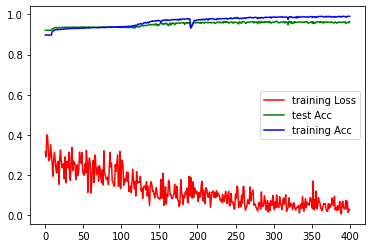

In [40]:
model2=train2(input,y_train,X_test,y_test,new_input,new_y_train)

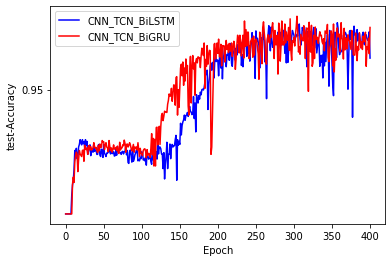

In [41]:
# plt.plot(epoch_list,loss_list,color='red',label='training Loss')
plt.xlabel("Epoch")
plt.ylabel("test-Accuracy")
plt.yticks([0.8,0.85,0.90,0.95,1])
plt.plot(epoch_list,ans_acc_list,color='blue',label='CNN_TCN_BiLSTM')
plt.plot(epoch_list2,ans_acc_list2,color='red',label='CNN_TCN_BiGRU')
plt.legend()
plt.show()

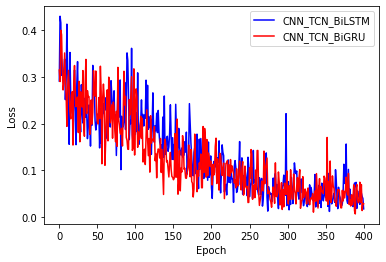

In [42]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epoch_list,loss_list,color='blue',label='CNN_TCN_BiLSTM')
plt.plot(epoch_list2,loss_list2,color='red',label='CNN_TCN_BiGRU')
# plt.yticks([0.8,0.85,0.90,0.95,1])
plt.legend()
plt.show()